In [254]:
import numpy as np
import pandas as pd

import torch
import torchvision
import torch.nn as nn   # neural network modules
import torch.optim as optim   # optimization algorithms
import torch.nn.functional as F   # functions without parameters like activation functions
from torch.utils.data import TensorDataset, DataLoader, Dataset   # dataset management, create batches
import torchvision.datasets as datasets   # standard datasets on pytorch
import torchvision.transforms as transforms   #transform datasets

import matplotlib.pyplot as plt

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [255]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [256]:
train_dataset = pd.read_csv("DailyDelhiClimateTrain.csv")

print(f"Full train dataset shape is {train_dataset.shape}")

Full train dataset shape is (1462, 5)


In [257]:
train_dataset.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [258]:
train_dataset.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


<Axes: >

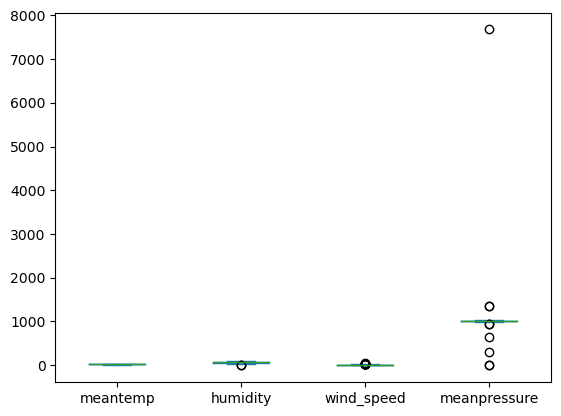

In [259]:
train_dataset.plot(kind='box')

In [260]:
# remove outliers

# remove using z-score
from scipy import stats

z_windspeed = np.abs(stats.zscore(train_dataset['wind_speed']))
z_meanpressure = np.abs(stats.zscore(train_dataset['meanpressure']))

z_data = [z_windspeed,z_meanpressure]
z_list = []
for x in z_data:
    z_list.extend(np.where(x>3)[0].flatten().tolist())

print(len(z_list))
train_dataset = train_dataset.drop(index = z_list, axis=0)

final_dataset = pd.DataFrame(train_dataset)
print(final_dataset.shape)

18
(1444, 5)


In [261]:
final_dataset['date'] = pd.to_datetime(final_dataset['date'])

final_dataset.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [262]:
feature_set = final_dataset.to_numpy()[:,[1,2,3,4]]
out_feature_index = 0 #meantemp
feature_set.shape

(1444, 4)

In [263]:
feature_set

array([[10.0, 84.5, 0.0, 1015.6666666666666],
       [7.4, 92.0, 2.98, 1017.8],
       [7.166666666666667, 87.0, 4.633333333333334, 1018.6666666666666],
       ...,
       [14.095238095238097, 89.66666666666667, 6.266666666666667,
        1017.904761904762],
       [15.052631578947368, 87.0, 7.325, 1016.1],
       [10.0, 100.0, 0.0, 1016.0]], dtype=object)

In [264]:
1444*0.8

1155.2

In [265]:
train_df = feature_set[:1155,:]
val_df = feature_set[1155:,:]

In [266]:
from sklearn.preprocessing import MinMaxScaler

cols_to_normalize = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']
ycol = ['meantemp']

scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(feature_set)
yscaled_data = scaler.fit_transform(feature_set[:,out_feature_index].reshape(-1,1))
# scaler expects 2d --> needs reshape
# The -1 in the first dimension indicates that the resulting array should have a size that is automatically determined to ensure that all the elements are included.
# The 1 in the second dimension indicates that the resulting array should have a single column.
# The purpose of this reshaping is to convert a 1-dimensional array (shape (n,)) into a 2-dimensional array with a single column (shape (n, 1)).

print(scaled_data.shape)
print(yscaled_data.shape)

(1444, 4)
(1444, 1)


In [267]:
# hyperparameters

input_size = 4   # num_features
sequence_length = 30   #blocksize

num_layers = 2
hidden_size = 256
learning_rate = 0.001
batch_size = 16
num_epochs = 6

In [268]:
x_train_data,y_train_data=[],[]
x_val_data,y_val_data=[],[]

for i in range(sequence_length, len(scaled_data)):
    if i < 1155:
        x_train_data.append(scaled_data[i - sequence_length : i,  :])
        y_train_data.append(yscaled_data[i])
        
    else:
        x_val_data.append(scaled_data[i - sequence_length : i,  :])
        y_val_data.append(yscaled_data[i])        
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
x_val_data,y_val_data=np.array(x_val_data),np.array(y_val_data)

print(x_train_data.shape)
print(y_train_data.shape)
print(x_val_data.shape)
print(y_val_data.shape)


(1125, 30, 4)
(1125, 1)
(289, 30, 4)
(289, 1)


In [269]:
x_train_data

array([[[0.12227074, 0.8209571 , 0.        , 0.53117921],
        [0.04279476, 0.90759076, 0.14965474, 0.53414746],
        [0.0356623 , 0.84983498, 0.23268466, 0.53535332],
        ...,
        [0.27001456, 0.49174917, 0.18581293, 0.53419384],
        [0.24836245, 0.60148515, 0.16258632, 0.5325126 ],
        [0.26637555, 0.65841584, 0.05308941, 0.53422697]],

       [[0.04279476, 0.90759076, 0.14965474, 0.53414746],
        [0.0356623 , 0.84983498, 0.23268466, 0.53535332],
        [0.08151383, 0.66886689, 0.06193764, 0.53326626],
        ...,
        [0.24836245, 0.60148515, 0.16258632, 0.5325126 ],
        [0.26637555, 0.65841584, 0.05308941, 0.53422697],
        [0.31179039, 0.60264026, 0.14865035, 0.53498229]],

       [[0.0356623 , 0.84983498, 0.23268466, 0.53535332],
        [0.08151383, 0.66886689, 0.06193764, 0.53326626],
        [0.        , 0.84790979, 0.18581293, 0.53233868],
        ...,
        [0.26637555, 0.65841584, 0.05308941, 0.53422697],
        [0.31179039, 0.602640

In [270]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True, bidirectional = True)
        # batch_first --> If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature)
        # bidirectional --> If True, becomes a bidirectional LSTM
        self.fc = nn.Linear(hidden_size * 2, 1)
        # need to multiply by 2 because one layer going forward and the other going backward
        
    def forward(self, x):
        # need to define hidden state and cell state to be sent into the LSTM
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        # need to multiply by 2 because one layer going forward and the other going backward
        # but they are all concatenated for the same hidden state
        # x.size(0) number of examples in a batch size 
        
        out, (hidden_state, cell_state) = self.lstm(x, (h0, c0))   # only output is used here
        out = self.fc(out[:, -1, :])   # take the last hidden state and send to the linear layer
        
        return out

In [271]:
model = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers).to(device)

In [272]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  

In [273]:
train_x = torch.tensor(x_train_data, dtype=torch.float32)
train_y = torch.tensor(y_train_data, dtype=torch.float32)
val_x = torch.tensor(x_val_data, dtype=torch.float32)
val_y = torch.tensor(y_val_data, dtype=torch.float32)

train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(val_x, val_y)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [274]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of iter(training_loader) so that we can track the batch index and do some intra-epoch reporting
    for index, data in enumerate(train_loader):

        # Every data instance is an input + label pair
        batch_x, batch_y = data
        
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(batch_x)

        # Compute the loss and its gradients
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item() #retrieves the scalar value of the loss function for the current batch
        if index % 10 == 9: #reports on loss every 10 batches
            last_loss = running_loss / 10 # loss per batch
            print(f'  batch {index + 1} loss: {last_loss}')
            tb_x = epoch_index * len(train_loader) + index + 1  #variable is used to set the x-axis value for the scalar summary in TensorBoard, based on the current epoch and batch index
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0

    return last_loss #last calculated batch loss

In [275]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(f'runs/spaceship_trainer_{timestamp}')
epoch_number = 0

EPOCHS = 10

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print(f'EPOCH {epoch_number + 1}:')

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer) # runs the training function above 

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for index, vdata in enumerate(val_loader):
        vbatch_x, vbatch_y = vdata
        voutputs = model(vbatch_x)
        vloss = criterion(voutputs.squeeze(), vbatch_y)
        running_vloss += vloss

    avg_vloss = running_vloss / (index + 1)
    print(f'LOSS: train {avg_loss} validation {avg_vloss}')

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()
    '''
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = f'model_{timestamp}_{epoch_number}'
        torch.save(model.state_dict(), model_path)
    '''
    epoch_number += 1

EPOCH 1:


/Users/pirey/miniconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  batch 10 loss: 0.13041657507419585
  batch 20 loss: 0.05921053886413574
  batch 30 loss: 0.04836498200893402
  batch 40 loss: 0.0451042665168643
  batch 50 loss: 0.053476500883698465
  batch 60 loss: 0.06104078963398933
  batch 70 loss: 0.04735032245516777


/Users/pirey/miniconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/pirey/miniconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


LOSS: train 0.04735032245516777 validation 0.05309533327817917
EPOCH 2:
  batch 10 loss: 0.05338359139859676
  batch 20 loss: 0.04525015316903591
  batch 30 loss: 0.046081884764134884
  batch 40 loss: 0.048356452584266664
  batch 50 loss: 0.04856464155018329
  batch 60 loss: 0.052419406548142436
  batch 70 loss: 0.05966016836464405
LOSS: train 0.05966016836464405 validation 0.04732178524136543
EPOCH 3:
  batch 10 loss: 0.0509306401014328
  batch 20 loss: 0.04455137252807617
  batch 30 loss: 0.05162761323153973
  batch 40 loss: 0.05437312461435795
  batch 50 loss: 0.04810599200427532
  batch 60 loss: 0.053768891468644144
  batch 70 loss: 0.050718089938163756
LOSS: train 0.050718089938163756 validation 0.05786284804344177
EPOCH 4:
  batch 10 loss: 0.04530147537589073
  batch 20 loss: 0.05537558607757091
  batch 30 loss: 0.04358202163130045
  batch 40 loss: 0.05522988401353359
  batch 50 loss: 0.04891060777008534
  batch 60 loss: 0.052239499613642694
  batch 70 loss: 0.046629863977432254


In [276]:
def check_mse(loader,model): 
    if loader == train_loader: 
        print("checking mse on training data")
    else:
        print("checking mse on test data")
    overall_loss = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad(): 
        for x,y in loader:
            x= x.to(device=device)
            y= y.to(device=device)
            
            outputs = model(x)
            unscaled_outputs = scaler.inverse_transform(np.array(outputs))
            unscaled_y = scaler.inverse_transform(np.array(y))
            
            unscaled_outputs = torch.from_numpy(unscaled_outputs)
            unscaled_y = torch.from_numpy(unscaled_y)            
            
            loss = F.mse_loss(unscaled_outputs,unscaled_y,reduction='sum')
            
            overall_loss += loss.item()
            num_samples += x.size(0)

        mse = overall_loss / num_samples
        print(f"MSE: {mse:.4f}")
        
    model.train()

In [277]:
check_mse(train_loader,model)
check_mse(val_loader,model)

checking mse on training data
MSE: 45.4095
checking mse on test data
MSE: 35.9500
